# Table of Contents


In [1]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import ipywidgets as widgets
import sys, os, io, string, shutil, math
from hublib.ui import Submit
from hublib.ui import RunCommand
import hublib.use
%use boost-1.62.0-mpich2-1.3-gnu-4.7.2
%use lammps-31Mar17
%set_env OMP_NUM_THREADS=4
import numpy as np
import re
import time
from threading import Thread
from io import StringIO
from ipywidgets import Layout, Box, Label, Output
from IPython.display import display,HTML
#sys.path.append('../python/')
#import train as nn
import random
import math
#from IPython.core.display import display, HTML
display(HTML("<style>.container { width:1300px !important; }</style>"))

style = {'description_width': 'initial'}

left_column='340px'
right_column='940px'
app_width='1280px'
app_height='700px'
column_heights= '900px'

form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    padding='5px'
)

form_item_layout_slider_text = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    padding='5px'
)

box_layout_image=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    #width='25%',
    padding='5px',
    #min_height='20px',
    #min_width='200px'
    width=left_column,
    #height='290px'
)
box_layout_phisical=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    #width='25%',
    padding='5px',
    #min_height='20px',
    #min_width='200px'
    width=left_column,
    #height='180px'
)
box_layout_computing=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=left_column,
    #height='103px'
)
box_layout_progress=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=left_column,
    ##height='55px'
)

box_layout_output=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=left_column,
    #height='150px'
)
box_layout_about=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=right_column,
    #height='136px'
)
form_item_layout_tab = Layout(
    display='flex',
    flex_flow='column',
    align_items='stretch',
    justify_content='space-between',
    padding='5px'
)

box_layout_tabs=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=right_column,
    height='100%'
)

button_hide_layout=Layout(
    visibility='hidden', #visible/hidden
    padding='5px',
    
)
button_show_layout=Layout(
    visibility='visible', #visible/hidden
    padding='5px',
    
)


<IPython.core.display.Javascript object>

env: OMP_NUM_THREADS=4


In [2]:
%%html
<style>
.jupyter-widgets.widget-tab > .p-TabBar .p-TabBar-tab {
    flex: 0 1 175px
}
</style>

In [3]:
epsilon = widgets.BoundedFloatText(
    value=1,
    min=1,
    max=10,
    step=1,
    description='Lennard jones well depth (KbT):',
    style=style,
)


In [4]:
concentration = widgets.BoundedFloatText(
    value=9.0,
    min=0.3,
    max=9.0,
    step=0.1,
    description='[Ligand - Virus] concentration (nM):',
    style=style
)

In [5]:
numberComplexes = widgets.BoundedIntText(
    value=108,
    min=1,
    max=1000,
    step=1,
    description='Number of vlp-ligand complexes:',
    style=style
)

In [6]:
wallSpacing = widgets.BoundedFloatText(
    value=100.0,
    min=10.0,
    max=200.0,
    step=10.0,
    description='Receptor spacing (nm):',
    style=style
)

In [7]:
time_in_mils = widgets.BoundedFloatText(
    value=275.0,
    min=100.0,
    max=5000.0,
    step=1.0,
    description='Simulation time (milliseconds):',
    style=style
)

In [8]:
imageSlider = widgets.IntSlider(
    value=0,
    min=0,
    max=0,
    step=10000,
    description='Images',
    style=style
)

In [9]:
submit_str = ''
def onToggleBtnChange(b):
    global submit_str
    if clustorMode.value:
        clustorMode.icon = 'check' 
        clustorMode.button_style='success'
        if not submit_str:
            output_image_warning_text.layout.visibility = 'visible'
    else:
        clustorMode.icon = '' 
        clustorMode.button_style=''
        if not submit_str:
            output_image_warning_text.layout.visibility = 'hidden'

clustorMode =widgets.ToggleButton(
    value=False,
    description='Cluster mode',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Simulation will run on a computing cluster when this button is turned on but you will loose the access to dynamic simulation snapshot slider.',
    icon='',
    style=style
)

clustorMode.observe(onToggleBtnChange,'value')

In [10]:
label_style = "style='background-color: #970cff; color:#ffffff; font-weight: bold; font-size:500; padding: 2px'"
label_style2 = "style='font-size:350; padding: 2px; font-weight: bold; align: center'"
def make_label(name, label_style, desc="",):
    lval = '<p %s %s>%s</p>' % (desc, label_style, name)
    return widgets.HTML(lval)

plabel = make_label('Input Parameters', label_style, '')
clabel = make_label('Computing Parameters',label_style, '')
olabel = make_label('Output Controllers', label_style, '')
imageSliderabout = make_label('Slide to navigate the simulation snapshots', label_style2, '')

In [11]:
'''
image_html = widgets.HTML(
    value='<img src="../images/overview.jpg" style="width: 500px"/>',
)
'''
file = open("../images/overview.png", "rb")
image = file.read()
image=widgets.Image(
    value=image,
    format='jpg',
    width=297,
    height=297,
)

form_items = [
    Box([image], layout=form_item_layout)
]

mainImage = Box(form_items, layout=box_layout_image)

In [12]:
form_items = [
    Box([plabel], layout=form_item_layout),
    Box([epsilon], layout=form_item_layout),
    Box([concentration], layout=form_item_layout),
    Box([numberComplexes], layout=form_item_layout),
    Box([wallSpacing], layout=form_item_layout)
]

form_items_computing = [
    Box([clabel], layout=form_item_layout),
    Box([time_in_mils], layout=form_item_layout),
    Box([clustorMode], layout=form_item_layout)
    
]

form_items_output = [
    Box([olabel], layout=form_item_layout),
    Box([imageSlider], layout=form_item_layout),
    Box([imageSliderabout], layout=form_item_layout)
]

physical_para = Box(form_items, layout=box_layout_phisical)
computing_para = Box(form_items_computing, layout=box_layout_computing)
output_para = Box(form_items_output, layout=box_layout_output)

In [13]:
about=widgets.Textarea(
    value='This app simulates the self-assembly of charged nanoparticles (NPs) into aggregates mediated by smaller, oppositely-charged linkers under different ionic physiological conditions. Users can input control parameters such as NP charge (from -500e to -1500e), linker density (from 25X to 100X the NP density), and ionic strength (from 0.01 M to 0.3 M) to predict formation of NP aggregates. This information may be useful in designing NP features to produce desired effects when NPs interface with biological entities. Outputs are structural information such as pair correlation functions (often denoted as g(r)) and simulation snapshots (with only NPs shown for clarity). The NPs are modeled after P22 virus-like particles (VLPs) of diameter 56 nanometers, and linkers represent smaller nanoparticles (dendrimers) of 6 nanometer diameter. Linker charge is fixed to about 35e Simulations are performed using LAMMPS; pre- and postprocessing are done using C++ codes. Simulation results are tested and validated using SAXS and dynamic light scattering measurements of the VLP aggregates; experiments also guide the model design. After you click Run, the application pre-processes the input parameters and loads the input script in the LAMMPS engine; this may take a couple of minutes after which the output log should appear in the Output text pane. As the output shows, the images will start to populate the "Simulation Snapshot" tab; the slider can be used to navigate through the images. At the end of simulation run, which will take close to 60 minutes, g(r) will be produced in the "Pair Correlation" tab. ',
    placeholder='',
    layout={'height': '186px','width': '100%'},
    disabled=True,
    style = {'font_weight': '150px'}
)

form_about = [
    Box([about], layout=form_item_layout)
]

about_text = Box(form_about, layout=box_layout_about)


In [14]:
def clear_All():
    
    localOutput.value = ''
    submit_str= ''
    progressBar.value=0
    imageSlider.max=0
    imageSlider.value=0 
    output_image.value=imageEmptyBox
    movie_download.layout = pair_core_download.layout =  button_hide_layout
    clustorMode.disabled = False
    
    if clustorMode.value:
        output_image_warning_text.layout.visibility = 'visible'
    else:
        output_image_warning_text.layout.visibility = 'hidden'
        
    plt.figure('Bound_receptors')
    plt.clf()  # clear old plot
    
    

In [15]:
def runPreprocessor(epsilon_value, concentration_value, numberComplexes_value, wallSpacing_value, simulationStepsToatal):
    preprocessingCMD = "./preprocessor -E "+str(epsilon_value)+" -C "+str(concentration_value)+" -S "+str(numberComplexes_value) + " -w "+str(wallSpacing_value) +" -T "+str(simulationStepsToatal) +" > preprocessor.log"
    
    try:
        !$preprocessingCMD
        
    except  Exception as e:
        localOutput.value = localOutput.value + "Error occured during the execution of preprocessing executable\n"
        sys.stderr.write('Error occured during the execution of preprocessing executable')
        sys.stderr.write(str(e))
        sys.exit(1)
    


In [16]:
runFlag=False
working_dir=""
parameter_append=""
sim_bigin=False
build_Plots=True
simulation_params=""

def callExe(s):
    global runFlag, working_dir, parameter_append, sim_bigin, ionsplot, build_Plots, simulation_params, nLigand_value, runName, simulationStepsToatal
    global submit_str, simulation_time_step
    if build_Plots:
        showPlotUI()
        build_Plots = False
    clear_All()
    
    #clustorMode.disabled = True
        
    epsilon_value = float(epsilon.value)
    concentration_value = float(concentration.value)
    numberComplexes_value = int(numberComplexes.value)
    wallSpacing_value = float(wallSpacing.value)
    simulationStepsToatal = float(time_in_mils.value)
    #Time to step conversion
    tau = 60e-9 * math.sqrt(3.819E-20 / ((1.38E-23) * (298.15)))
    simulation_time_step = math.ceil(simulationStepsToatal * 1e-3 / tau)
    total_processors = 64
    walltime = 60
    runName='nanobind'
    
    #Adding standard outputs to string to be sent to output widget callback function
    parameter_append= "Lennard jones well depth is "+ str(epsilon_value)+"\n"
    parameter_append= parameter_append + "[Ligand - Virus] complex concentration is "+ str(concentration_value)+"\n"
    parameter_append= parameter_append + "Number of vlp-ligand complexes are "+ str(numberComplexes_value)+"\n"
    parameter_append= parameter_append + "Receptor spacing is "+ str(wallSpacing_value)+"\n"
    parameter_append= parameter_append + "Simulation time is "+ str(simulationStepsToatal)+"\n"
    parameter_append= parameter_append + "requested walltime is "+ str(walltime)+" (mins)\n"
    parameter_append= parameter_append + "requested total processors are "+ str(total_processors)+"\n"
    
    simulation_params="_%.2f" % epsilon_value+ "_%.2f" % concentration_value+ "_%d" % numberComplexes_value+ "_%.2f" % wallSpacing_value+ "_%.2f" % simulationStepsToatal

    shutil.rmtree('outfiles',True)
    if not os.path.exists('outfiles'):
        os.makedirs('outfiles')
     
    localOutput.value = localOutput.value + "Preprocessing is running...\n"
    
    #preprocessing stage
    runPreprocessor(epsilon_value, concentration_value, numberComplexes_value, wallSpacing_value, simulationStepsToatal)
    
    localOutput.value = localOutput.value + "Preprocessing completed\n"
        
    localOutput.value = localOutput.value +  parameter_append;
  

    runFlag=True
    sim_bigin=True
    
    #starting a thread for on the fly density plot
    #t2 = Thread(target=iterative_density_plot)
    #t2.start()
    
    try:
        #rname = s.make_rname(e_np_value, e_out_value, pion_value, c_out_value, np_radius_value, np_charge_value, sim_steps_value)
        submit_str = ''
        if clustorMode.value:
            submit_str = '--venue standby@brown -n '+str(total_processors)+' -N 16'+' -w '+str(walltime)+' -e OMP_NUM_THREADS=1'+' --tailStdout 1000 ' +'--inputfile '+'infiles '+'--inputfile '+'outfiles '+'lammps-31Mar17-parallel -in in.lammps'
            #submit_str = '-n '+str(total_processors)+' -w '+str(walltime)+' -N 20'+' -e OMP_NUM_THREADS=1'+' --tailStdout 1000 ' +'--inputfile '+'outfiles '+'lammps-31Mar17-parallel -in in.lammps' 
            #submit_str = '--venue standby@rice ' + '-n 32 -w 60 -N 16'+' --tailStdout 1000 ' +'--inputfile '+'outfiles '+'lammps-31Mar17-parallel -in in.lammps'
            localOutput.value = localOutput.value + "LAMMPS input script designed and simulation submitted to the cluster, waiting for response...\n"
        else:
            submit_str = '--local stdbuf -o0 -e0 lmp_serial -in in.lammps'
            localOutput.value = localOutput.value + "LAMMPS input script designed and simulation running...\n"

        s.run(runName, submit_str)
        
        time.sleep(1)
        
    except  Exception as e:
        sys.stderr.write('Error occured during the execution of Lammps program')
        sys.stderr.write(str(e))
        sys.exit(1)
    
    runFlag = False
    #t2.join()

In [17]:
def doneFunc(s, rdir):
    global submit_str    
    #this is a condtional variable for few things
    submit_str = ''
    
    progressBar.value=int(100)
    
    localOutput.value = localOutput.value + "LAMMPS simulation finished\n" 
    
    submit_btn.but.disabled = True
    clustorMode.disabled = False
    
    localOutput.value = localOutput.value + "Postprocessing is running...\n"
    
    #postprocessing stage
    postprocessingCMD = "./postprocessor > postprocessor.log"
    try:
        !$postprocessingCMD
        
    except  Exception as e:
        localOutput.value = localOutput.value + "Error occured during the execution of postprocessing executable\n"
        sys.stderr.write('Error occured during the execution of postprocessing executable')
        sys.stderr.write(str(e))
        sys.exit(1)
        
    localOutput.value = localOutput.value + "Postprocessing is finished\n"
    
    #  Plotting the result
    #plot_data()
    
    localOutput.value = localOutput.value + "Simulation ended\n"
    
    submit_btn.but.disabled = False
    
    #image slider fully ready
    imageSlider.max=simulationStepsToatal
    imageSlider.value=simulationStepsToatal
    
    movie_download.layout = pair_core_download.layout = button_show_layout

In [18]:
# after the run finished, optionally do something
# with the output
#def plot_data(s, rdir):
def plot_data():    
    #We ignore rdir because submit puts non-parametric runs in the current directory
    # When caching is enabled, they get put in a chached directory and rdit is always used. 
    #wait for 2 seconds before plotting errorBars.
    time.sleep(2)  
    plt.figure('Bound_receptors')
    plt.clf()  # clear old plot
    plt.title('NP-NP Pair correlation function')
    plt.xlabel('Distance (in units of NP diameter)', fontsize=10)
    plt.ylabel('g(r)', fontsize=10)
    
    # our simulation writes to outfiles -> density_profile.dat
    try:
        density_profile = np.loadtxt(working_dir + 'outfiles/gr_VV_dr=0.005.out')
    except:
        sys.stderr.write('Can not find the pair correlation results file')
        sys.exit(1)
    #print(density_profile)    
    x = density_profile[:,0]
    # droping data above 4.3 in x dim.
    #x = numpy.select([ x < 4.3 ],x)
    y = density_profile[:x.size,1]
    #yrr = density_profile[:,2]
    #plt.errorbar(x,y,xerr=0.0, yerr=yrr, c='b', ecolor='r', capsize=2)
    plt.plot(x,y)
    plt.show()
    

In [19]:
in_wrapper_progress = False
saved_data = ""
saved_data_enery = ""
saved_data_ions_pos = ""
stepNumber = 0

def stdoutput_handler(buffer):
    global in_wrapper_progress, saved_data, parameter_append, sim_bigin, stepNumber, saved_data_enery, saved_data_ions_pos
    output = []

    #return buffer

    if sim_bigin:
        #output.append(parameter_append)
        sim_bigin = False
   
    data = buffer.split('\n')
    
    last = len(data) - 1
    
    for i, line in enumerate(data):
        
        output.append(line)
        
        if line.startswith('Loop time of '):
            in_wrapper_progress = False
            continue
        
        if in_wrapper_progress:
            number = line.split()
            if number:
                if number[0].isdigit():
                    #print(number[0])
                    percent = float(number[0])/simulation_time_step*100
                    progressBar.value=int(percent)
                    # This adjust the image slider dynamically
                    # dynamic update only happens for local VM run
                    if submit_str.startswith('--local '):
                        if(int(number[0])%imageSlider.step == 0):
                            imageSlider.max=number[0]
                            imageSlider.value=number[0]            
            continue
        
        if line.startswith('Step Temp TotEng KinEng PotEng'):
            in_wrapper_progress = True
            
            
    reduced_buffer = '\n'.join(output)
    
    #appending new line at the end
    if reduced_buffer:
        if reduced_buffer[-1] != '\n':
            reduced_buffer = reduced_buffer + '\n'
    
    
    return reduced_buffer

In [20]:
#button_style = "style='background-color: #81c4fd; font-size:500; padding: 4px; -webkit-appearance: button; -moz-appearance: button; appearance: button; text-decoration: none; color: initial;'"

def make_downloadBtn(downFilename="", downloadURL="", displayText=""):
    bval = "<a download='%s' href='%s'><button class='p-Widget jupyter-widgets jupyter-button widget-button mod-info'>%s</button></a>" % (downFilename, downloadURL, displayText)
    return widgets.HTML(bval)

#from IPython.display import FileLink, FileLinks
#FileLinks('outfiles')
#FileLinks('data')

<IPython.core.display.Javascript object>


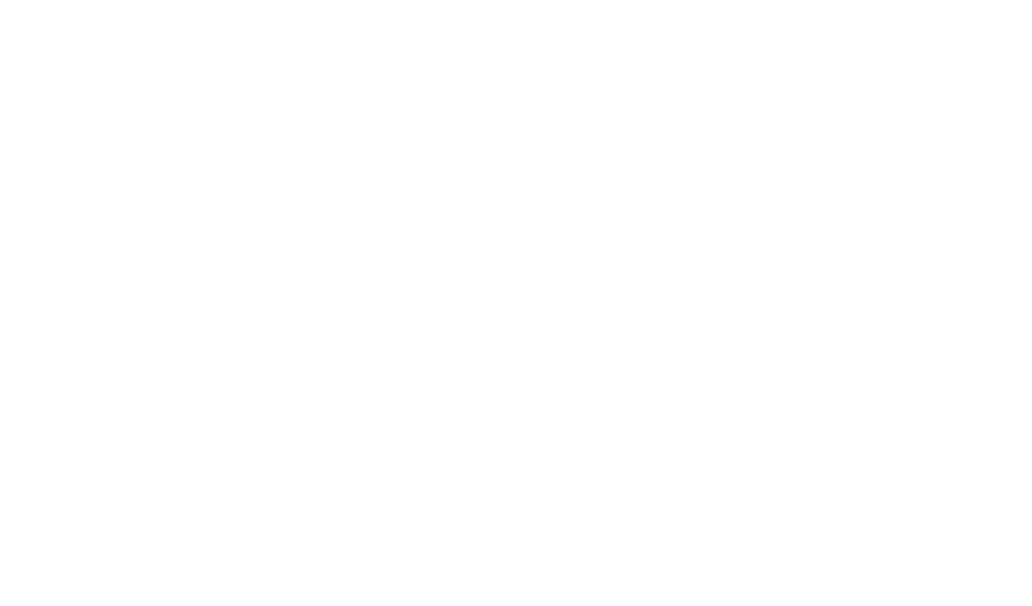

In [21]:
tab_layout=Layout(
    width='100%',
    height='586px',
    justify_content='space-between',
)

# we want the plot to go here, so create an empty one initially
#create tabs
figsize_tup=(8.60, 5.05)
figure_density_pos = plt.figure(num='Bound_receptors', figsize=figsize_tup)
out_desnity_pos = Output(layout=tab_layout)

file = open("../images/image.emptybox.jpg", "rb")
imageEmptyBox = file.read()

output_image=widgets.Image(
    format='jpg',
    width=584,
    height=584,
    value=imageEmptyBox
)
#out_output_image = Output(layout=tab_layout)


output_image_layout=Layout(
    display='flex',
    flex_flow='row',
    #border='solid 2px',
    align_items='stretch',
    margin = '0px 0px 0px 130px' #top, right, bottom and left
)

box_layout_warning_text=Layout(
    display='flex',
    flex_flow='row',
    #border='solid 1px',
    align_items='stretch',
    padding='5px',
    width='140px',
    visibility = 'hidden'
    #height='136px'
)

#label_style3 = "style='background-color: #eeeeee; color: #388e3c; font-size:350; padding: 2px; font-weight: bold; align: center'"
label_style3 = "style='background-color: #eeeeee; font-size:350; padding: 2px; font-weight: bold; align: center'"
output_image_warning_text = make_label('Cluster mode is on! You will loose the access to the dynamic simulation snapshot data. Snapshot data will be available at the end of simulation.', label_style3, '')

form_output_image_sec = [
    Box([output_image], layout=output_image_layout),
    Box([output_image_warning_text], layout=box_layout_warning_text)
]
output_image_section = Box(form_output_image_sec, layout=tab_layout)

#data download tab
movie_download = make_downloadBtn(downFilename="movie.melt", downloadURL="outfiles/ovito_movie.melt", displayText="Movie")
pair_core_download = make_downloadBtn(downFilename="bound_receptors.dat", downloadURL="outfiles/ovito_movie.melt.processed", displayText="Number of receptors bound")

movie_download.layout = pair_core_download.layout =  button_hide_layout

box_layout_outputs=Layout(
    display='flex',
    flex_flow='column',
    align_items='stretch',
    padding='5px'
)
form_output_content = [
    Box([movie_download], layout=box_layout_outputs),
    Box([pair_core_download], layout=box_layout_outputs)
]
downloadMovieSec = Box(form_output_content, layout=tab_layout)



In [22]:
def onSliderChange(b):
    
    value = imageSlider.value
    valueText = str(value)
    if value==0:
        valueText = "000"
    
    fileName="image."+valueText+".jpg"
    fileName="outfiles/"+fileName;
    try:
        file = open(fileName, "rb")
        selectedImage = file.read()
        output_image.value=selectedImage
    except:
        sys.stderr.write('Image file is not there yet.')
       
    
imageSlider.observe(onSliderChange, names='value')

In [23]:
#tabChange detection and plot data incase automatically not drawn
def onTabChange(b):
    if os.path.isfile('outfiles/gr_VV_dr=0.005.out'):
        plot_data()

In [24]:
tab_contents = ['Bound_receptors', 'Simulation Snapshot', 'Downloads']
children = [out_desnity_pos, output_image_section, downloadMovieSec]
tabSpace = widgets.Tab()
tabSpace.children = children
for i in range(len(children)):
    tabSpace.set_title(i, str(tab_contents[i]))
tabSpace.selected_index = 1

tabSpace.observe(onTabChange, names='selected_index')

form_about = [
    Box([tabSpace], layout=form_item_layout_tab)
]

tab = Box(form_about, layout=box_layout_tabs)

In [25]:
def showPlotUI():
    with out_desnity_pos:
        display(figure_density_pos, layout=tab_layout)
    #with out_output_image:
    #    display(output_image, layout=tab_layout)

In [26]:
form_item_layout_output = Layout(
    display='flex',
    flex_flow='column',
    justify_content='space-between',
    padding='4px'
)

form_item_layout_run_btn = Layout(
    display='flex',
    flex_flow='column',
    justify_content='space-between',
    padding='4px'
)

#Submit(start_func=callExe, done_func=plot_data, cachename='SubmitTest1')
submit_btn=Submit(start_func=callExe, done_func=doneFunc, outcb=stdoutput_handler)

submit_btn.acc.set_title(0, "LAMMPS Output")
submit_btn.w.layout = form_item_layout_run_btn
#submit_btn.acc.layout = form_item_layout_output
localOutput = widgets.Textarea(layout={'width': '100%', 'height': '250px'})
localOutputWidget = widgets.Accordion(children=[localOutput],layout=form_item_layout_output)
localOutputWidget.set_title(0, "Output")
localOutputWidget.selected_index = None
localOutput.value = ""


In [27]:
progressBar=widgets.IntProgress(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Progress:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal',
    layout={'width': '100%'},
    style=style
)

form_items_progress = [
    Box([progressBar], layout=form_item_layout)
]

progressBar_Ele = Box(form_items_progress, layout=box_layout_progress)

In [28]:
form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    padding='5px'
)

box_layout_column_left=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 2px',
    align_items='stretch',
    width=left_column,
    height=column_heights
)
box_layout_column_right=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 2px',
    align_items='stretch',
    width=right_column,
    height=column_heights
)

box_layout=Layout(
    display='flex',
    flex_flow='row',
    #border='solid 2px',
    align_items='stretch',
    width=app_width,
    #padding='5px',
    height='900px'
)

box_layout_rows=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 2px',
    align_items='stretch',
    width=app_width,
    #padding='5px',
    height='2000px',
    #overflow_x='scroll',
    #overflow_y='scroll'
)


gui_left = [
    Box([mainImage], layout=form_item_layout),
    Box([physical_para], layout=form_item_layout),
    Box([computing_para], layout=form_item_layout),
    Box([progressBar_Ele], layout=form_item_layout),
    Box([output_para], layout=form_item_layout)
]

gui_right = [
    Box([about_text], layout=form_item_layout),
    Box([tab], layout=form_item_layout)
]

form_left = Box(gui_left, layout=box_layout_column_left)
form_right = Box(gui_right, layout=box_layout_column_right)

gui_upper = [
    Box([form_left], layout=box_layout_column_left),
    Box([form_right], layout=box_layout_column_right)
]

form = Box(gui_upper, layout=box_layout)

gui = widgets.VBox([form, localOutputWidget, submit_btn.w],layout=box_layout_rows)


In [29]:
gui

VBox(children=(Box(children=(Box(children=(Box(children=(Box(children=(Box(children=(Box(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xe8\x00\x00\x03\xa0\x08\x02\x00\x00\x00!\xca\xcb\xb2\x00\x00\x00\tpHYs\x00\x00\x0b\x13\x00\x00\x0b\x13\x01\x00\x9a\x9c\x18\x00\x00\x06=iTXtXML:com.adobe.xmp\x00\x00\x00\x00\x00<?xpacket begin="\xef\xbb\xbf" id="W5M0MpCehiHzreSzNTczkc9d"?> <x:xmpmeta xmlns:x="adobe:ns:meta/" x:xmptk="Adobe XMP Core 5.6-c142 79.160924, 2017/07/13-01:06:39        "> <rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"> <rdf:Description rdf:about="" xmlns:xmp="http://ns.adobe.com/xap/1.0/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:photoshop="http://ns.adobe.com/photoshop/1.0/" xmlns:xmpMM="http://ns.adobe.com/xap/1.0/mm/" xmlns:stEvt="http://ns.adobe.com/xap/1.0/sType/ResourceEvent#" xmp:CreatorTool="Adobe Photoshop CC (Windows)" xmp:CreateDate="2019-04-10T12:58:49-04:00" xmp:ModifyDate="2019-04-10T18:46:53-04:00" xmp:MetadataDate="2019-04-10T18:46:53-04:00" dc:format="image/png" photoshop:ColorMode="3" photoshop:ICCProfile="sRGB IEC61966-2.1" xmpMM:InstanceID="xmp.iid:44fdcff2-39ac-6741-bbe2-ffe81d50a5ff" xmpMM:DocumentID="adobe:docid:photoshop:67f4f0b0-bc12-cd4d-b90a-7e895cce6fb7" xmpMM:OriginalDocumentID="xmp.did:2c7b3bc3-cdb3-1f43-be7c-4bc2aa69ee0c"> <xmpMM:History> <rdf:Seq> <rdf:li stEvt:action="created" stEvt:instanceID="xmp.iid:2c7b3bc3-cdb3-1f43-be7c-4bc2aa69ee0c" stEvt:when="2019-04-10T12:58:49-04:00" stEvt:softwareAgent="Adobe Photoshop CC (Windows)"/> <rdf:li stEvt:action="converted" stEvt:parameters="from image/gif to image/png"/> <rdf:li stEvt:action="saved" stEvt:instanceID="xmp.iid:44fdcff2-39ac-6741-bbe2-ffe81d50a5ff" stEvt:when="2019-04-10T18:46:53-04:00" stEvt:softwareAgent="Adobe Photoshop CC (Windows)" stEvt:changed="/"/> </rdf:Seq> </xmpMM:History> </rdf:Description> </rdf:RDF> </x:xmpmeta> <?xpacket end="r"?>\xa3\xfb$\xc2\x00\x03\xd9\xa6IDATx\x9c\xec\xddg`\x15U\xfe7\xf0s\xa6\xde\xde\xd3{\x83\x10zG\x01\xb1a\xef\r\x95b\xc3\x06\xd8X\xc5\xbe*H\x15\x05\x04\x1b\n\x16\xec\x8aX\xd7.\xa2 \xbdwHBz\xcf\xcd\xedw\xfay^\xb0\x7f\x9f-\xaeR\x92L&\xf9}\xde,+\xc9\xcc\xf7^\xee\x9d\xf9\xcd\xa9\x98\x10\x82\x00\x00\x00\x00\x00\x00\x00\x1d\x1b\xa5w\x00\x00\x00\x00\x00\x00\x00\xc0_\x83\xc2\x1d\x00\x00\x00\x00\x00\x00\x03\x80\xc2\x1d\x00\x00\x00\x00\x00\x00\x03\x80\xc2\x1d\x00\x00\x00\x00\x00\x00\x03\x80\xc2\x1d\x00\x00\x00\x00\x00\x00\x03\x80\xc2\x1d\x00\x00\x00\x00\x00\x00\x03\x80\xc2\x1d\x00\x00\x00\x00\x00\x00\x03\x80\xc2\x1d\x00\x00\x00\x00\x00\x00\x03`\xf4\x0e\x00\x00\x00\xa0S\x91$\tc\xdc\x16G>\x96\x1d\x03\t!\x1c\xc7\xb5Q\x00\x00\x00\xd0\x97\x91\n\xf7H$\xf2\xcc3\xcf\x94\x95\x95\xfd\xeb\x15\xb9\xb5v~=\xc6\xc3X\xad\x16\x97\xcb\xd5*g<.\xb0\xc1-hk\x84\x10\x9a\xa6\xbd^/\xc7q\xf0y;v\xaa\xaav\xeb\xd6\xed\xc2\x0b/\xd4;H\x87PSS\xb3h\xd1\xa2\x1d;vX,\x96V?8!\xe4X>\x99\xaa\xaaz<\x1e\x9b\xcd\xa6iZ\xabg0:\xf8j\xff\xaes\xbc\x15\x9a\xa69\x1c\x0e\x9b\xcd\x861\x0c\xa08>G\xaf\x0f\x97^z\xc9\xa0A\x83\xf4\xcer|\x8cT\xb8\xef\xdb\xb7\xef\x85\x17^hnn\xd6;\x08\x00\x9d\x16EQ4Mu\x8a;Z\x9b\xa3(\ncL\x08\xe9\xdb\xb7\xef\xc0\x81\x03\x93\x93\x93\xf5N\xa4\xbf\xe2\xe2\xe2\x15+V\xd4\xd6\xd6\xea\x1d\x04\x00\x00\xfe\'\x8a\xc2\x84\x1cm\x0b\xd0\xa0poC\xd1X\x8c\xa6\xe9\xa3\x7ff\x18\xa6G\x8f\x1e\x19\x19\x19\xb2,\xb7s\x8c\xce\xf1\x98\xde1a\x8c\xab\xaa\xaa"\x91\xa8\xdeA\xba\xaecl\xd4\x04\x0c\xc3\xb4\xb4\xf8c\xb1\x98\xa6iMMM\xd1(|h\x11BH\x96\xe5\xdf\xaf\xd2\x08\xa1\xfe\xfd\xfb\'$$\xb4\xf3\'\xea\xe8\xd3\x14|\x8c\xdb\x1aEQuuu\x81@@\xef ]\x1c|\xda\x8f\x0f\xc6X\xd3\xd4\xa6\xa6&B\x88$IF\xbct\x1b\xa9p\xa7(\x8a\xa2\xfe\xd9\x19\xa4(Jaa\xe1k\xaf\xbd\x86\xa0\x92\xeeD0\xc6\xb2,C\x077\xe8\xe00\xc6\xdb\xb6o\x1fs\xcd5V\xabUQ\x14\x9a\xa6\x7f\xbf4uq\x18\xe3\x7f\x1d\xca\xe8\xf7\xfb?\xfb\xec3\xa7\xd3\tW\xe9\xce\x07c\xac(\x8a\xaa\xaaz\x07\x01\xe08\x08\x82\xf0\xe4\x93O\xbe\xf1\xc6\x1bn\xb7\xbb\xb9\xb9\xd9\x88\x93a\x8cT\xb8c\x84\x08!,\xcb\x16\x15\x15\xed\xdb\xb7\xef\x93O>\xc9\xc8\xc8\x981cF[\x0c\xa6\x04\x00\x80\xff%\x18\x0c\xbe\xb0